# Advanced Text Vectorization for Toxic Comment Classification

This notebook compares traditional vectorization methods (TF-IDF, Count) with advanced embedding techniques (Word2Vec, GloVe, FastText) on the toxic comment classification task.

In [1]:
# !pip install xgboost

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
import nltk
import time
import gensim
from gensim.models import Word2Vec, FastText
from tqdm.notebook import tqdm
import warnings
import torch
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from itertools import product
import pandas as pd
import os
warnings.filterwarnings('ignore')

In [3]:
import multiprocessing
n_cores = multiprocessing.cpu_count()
print(f"Available CPU cores: {n_cores}")

Available CPU cores: 16


In [4]:
# Download necessary NLTK resources
nltk.download('punkt', quiet=True)

True

In [5]:
# Load preprocessed data
train_data = pd.read_csv('../Dataset/train_preprocessed.csv')

# Check the data
print(f"Training data shape: {train_data.shape}")
train_data.head()

Training data shape: (159571, 12)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,processed_text,original_length,processed_length,length_reduction
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edits made my username hardcore me...,264,202,23.484848
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,daww ! he match background colour im seemingly...,112,86,23.214286
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"hey man , im really not trying edit war . guy ...",233,165,29.184549
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,i cant make real suggestion improvement i wond...,622,406,34.726688
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"you , sir , my hero . chance you remember page...",67,54,19.402985


In [6]:
# Define the features and target labels
X = train_data['processed_text']  # Use the preprocessed text
y = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# Handle missing values
X = X.fillna("")  # Replace NaN values with empty strings
y = y.fillna(0)   # Replace any missing target values with 0

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y['toxic']
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 127656
Validation set size: 31915


## 1. Define Advanced Vectorizers

Let's implement custom vectorizers for Word2Vec, GloVe, and FastText embeddings.

In [7]:
# Word2Vec Vectorizer
class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, window=5, min_count=1, workers=4, sg=1):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.sg = sg  # 0 for CBOW, 1 for Skip-gram
        self.model = None
        self.word_vectors = None
        
    def fit(self, X, y=None):
        # Tokenize the text
        tokenized_corpus = [nltk.word_tokenize(text.lower()) for text in tqdm(X, desc="Tokenizing for Word2Vec")]
        
        # Train Word2Vec model
        print("Training Word2Vec model...")
        self.model = Word2Vec(
            sentences=tokenized_corpus,
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            workers=self.workers,
            sg=self.sg
        )
        
        self.word_vectors = self.model.wv
        print(f"Word2Vec model trained with {len(self.word_vectors.key_to_index)} words")
        return self
    
    def transform(self, X):
        tokenized_corpus = [nltk.word_tokenize(text.lower()) for text in tqdm(X, desc="Vectorizing with Word2Vec")]
        
        # Create document vectors by averaging word vectors
        doc_vectors = np.zeros((len(tokenized_corpus), self.vector_size))
        for i, tokens in enumerate(tokenized_corpus):
            vec = np.zeros(self.vector_size)
            count = 0
            for token in tokens:
                if token in self.word_vectors:
                    vec += self.word_vectors[token]
                    count += 1
            if count > 0:
                vec /= count
            doc_vectors[i] = vec
        
        return doc_vectors

In [8]:
# FastText Vectorizer
class FastTextVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, window=5, min_count=1, workers=4):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.model = None
        
    def fit(self, X, y=None):
        # Tokenize the text
        tokenized_corpus = [nltk.word_tokenize(text.lower()) for text in tqdm(X, desc="Tokenizing for FastText")]
        
        # Train FastText model
        print("Training FastText model...")
        self.model = FastText(
            sentences=tokenized_corpus,
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            workers=self.workers
        )
        
        print(f"FastText model trained with {len(self.model.wv.key_to_index)} words")
        return self
    
    def transform(self, X):
        tokenized_corpus = [nltk.word_tokenize(text.lower()) for text in tqdm(X, desc="Vectorizing with FastText")]
        
        # Create document vectors by averaging word vectors
        doc_vectors = np.zeros((len(tokenized_corpus), self.vector_size))
        for i, tokens in enumerate(tokenized_corpus):
            vec = np.zeros(self.vector_size)
            count = 0
            for token in tokens:
                # FastText can handle OOV words
                vec += self.model.wv[token]
                count += 1
            if count > 0:
                vec /= count
            doc_vectors[i] = vec
        
        return doc_vectors

In [9]:
# GloVe - Using pre-trained embeddings
class GloveVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100):
        self.vector_size = vector_size
        self.word_vectors = {}
        
    def fit(self, X, y=None):
        # Attempt to download pre-trained GloVe using gensim downloader
        try:
            import gensim.downloader as api
            print("Downloading pre-trained GloVe embeddings...")
            # Use a smaller model for demonstration
            glove_model = api.load("glove-wiki-gigaword-100")
            self.word_vectors = {word: glove_model[word] for word in glove_model.key_to_index}
            print(f"Loaded GloVe embeddings with {len(self.word_vectors)} words")
        except Exception as e:
            print(f"Error loading GloVe: {e}")
            print("Will use an empty embedding. Results will be poor.")
        
        return self
    
    def transform(self, X):
        tokenized_corpus = [nltk.word_tokenize(text.lower()) for text in tqdm(X, desc="Vectorizing with GloVe")]
        
        # Create document vectors by averaging word vectors
        doc_vectors = np.zeros((len(tokenized_corpus), self.vector_size))
        for i, tokens in enumerate(tokenized_corpus):
            vec = np.zeros(self.vector_size)
            count = 0
            for token in tokens:
                if token in self.word_vectors:
                    vec += self.word_vectors[token]
                    count += 1
            if count > 0:
                vec /= count
            doc_vectors[i] = vec
        
        return doc_vectors

## 2. Define Model Evaluation Function

In [10]:
def evaluate_model(model, X, y, model_name):
    start_time = time.time()
    y_pred = model.predict(X)
    inference_time = time.time() - start_time
    
    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y, y_pred)
    
    # Calculate F1 scores for each class
    f1_scores = []
    for i, column in enumerate(y.columns):
        f1 = f1_score(y[column], y_pred[:, i])
        f1_scores.append(f1)
    
    # Calculate macro and micro F1
    macro_f1 = np.mean(f1_scores)
    micro_f1 = f1_score(y, y_pred, average='micro')
    
    print(f"\n============ {model_name} Results ============")
    print(f"Inference time: {inference_time:.2f} seconds")
    print(f"Validation accuracy: {accuracy:.4f}")
    print(f"Macro F1: {macro_f1:.4f}")
    print(f"Micro F1: {micro_f1:.4f}")
    
    print("\nF1 scores by toxicity type:")
    for i, column in enumerate(y.columns):
        f1 = f1_score(y[column], y_pred[:, i])
        print(f"{column}: {f1:.4f}")
    
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'micro_f1': micro_f1,
        'inference_time': inference_time
    }
    
    for i, column in enumerate(y.columns):
        results[f'f1_{column}'] = f1_scores[i]
    
    return results, y_pred

## 3. Train and Evaluate Traditional Models

In [11]:
# TF-IDF Vectorizer
print("\n\n================ PREPARING TF-IDF VECTORS ================")
tfidf_vectorizer = TfidfVectorizer(
    max_features=20000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2)
)

print("Fitting TF-IDF vectorizer...")
start_time = time.time()
tfidf_vectorizer.fit(X_train)
train_time = time.time() - start_time
print(f"TF-IDF vectorizer fitted in {train_time:.2f} seconds")

# Transform training and validation data
print("Transforming data with TF-IDF...")
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
print(f"TF-IDF vectors shape: {X_train_tfidf.shape}")




================ PREPARING TF-IDF VECTORS ================
Fitting TF-IDF vectorizer...
TF-IDF vectorizer fitted in 11.55 seconds
Transforming data with TF-IDF...
TF-IDF vectors shape: (127656, 20000)


In [12]:


# Count Vectorizer
print("\n\n================ PREPARING COUNT VECTORS ================")
count_vectorizer = CountVectorizer(
    max_features=20000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2)
)

print("Fitting Count vectorizer...")
start_time = time.time()
count_vectorizer.fit(X_train)
train_time = time.time() - start_time
print(f"Count vectorizer fitted in {train_time:.2f} seconds")

# Transform training and validation data
print("Transforming data with Count Vectorizer...")
X_train_count = count_vectorizer.transform(X_train)
X_val_count = count_vectorizer.transform(X_val)
print(f"Count vectors shape: {X_train_count.shape}")



================ PREPARING COUNT VECTORS ================
Fitting Count vectorizer...
Count vectorizer fitted in 11.62 seconds
Transforming data with Count Vectorizer...
Count vectors shape: (127656, 20000)


## 4. Train Word2Vec Model

In [13]:
# Word2Vec + SVM
w2v_vectorizer = Word2VecVectorizer(vector_size=500, window=5, min_count=1, workers=n_cores, sg=1)

# Fit the vectorizer to get word embeddings
print("Fitting Word2Vec vectorizer...")
start_time = time.time()
w2v_vectorizer.fit(X_train)
train_time = time.time() - start_time
print(f"Word2Vec training completed in {train_time:.2f} seconds")

# Transform training data
print("Transforming training data with Word2Vec...")
X_train_w2v = w2v_vectorizer.transform(X_train)

# # Train classifier
# w2v_classifier = MultiOutputClassifier(LinearSVC(
#     C=1.0,
#     max_iter=10000,
#     dual=False,
#     class_weight='balanced',
#     random_state=42
# ))

# print("Training Word2Vec + SVM classifier...")
# start_time = time.time()
# w2v_classifier.fit(X_train_w2v, y_train)
# train_time = time.time() - start_time
# print(f"Classifier training completed in {train_time:.2f} seconds")

# Transform validation data and evaluate
print("Transforming validation data with Word2Vec...")
X_val_w2v = w2v_vectorizer.transform(X_val)

# # Create a class for evaluation that behaves like a pipeline
# class ModelWrapper:
#     def __init__(self, vectorizer, classifier):
#         self.vectorizer = vectorizer
#         self.classifier = classifier
    
#     def predict(self, X):
#         X_transformed = self.vectorizer.transform(X)
#         return self.classifier.predict(X_transformed)

# w2v_model = ModelWrapper(w2v_vectorizer, w2v_classifier)
# w2v_results, w2v_preds = evaluate_model(w2v_model, X_val, y_val, "Word2Vec + SVM")

Fitting Word2Vec vectorizer...


Tokenizing for Word2Vec:   0%|          | 0/127656 [00:00<?, ?it/s]

Training Word2Vec model...
Word2Vec model trained with 167976 words
Word2Vec training completed in 103.88 seconds
Transforming training data with Word2Vec...


Vectorizing with Word2Vec:   0%|          | 0/127656 [00:00<?, ?it/s]

Transforming validation data with Word2Vec...


Vectorizing with Word2Vec:   0%|          | 0/31915 [00:00<?, ?it/s]

In [14]:
# Additional imports for multiple classifiers
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from itertools import product
import pandas as pd

## 5. Train FastText Model

In [15]:
# FastText + SVM
fasttext_vectorizer = FastTextVectorizer(vector_size=500, window=5, min_count=1, workers=n_cores)

# Fit the vectorizer to get word embeddings
print("Fitting FastText vectorizer...")
start_time = time.time()
fasttext_vectorizer.fit(X_train)
train_time = time.time() - start_time
print(f"FastText training completed in {train_time:.2f} seconds")

# Transform training data
print("Transforming training data with FastText...")
X_train_fasttext = fasttext_vectorizer.transform(X_train)

# # Train classifier
# fasttext_classifier = MultiOutputClassifier(LinearSVC(
#     C=1.0,
#     max_iter=10000,
#     dual=False,
#     class_weight='balanced',
#     random_state=42
# ))

# print("Training FastText + SVM classifier...")
# start_time = time.time()
# fasttext_classifier.fit(X_train_fasttext, y_train)
# train_time = time.time() - start_time
# print(f"Classifier training completed in {train_time:.2f} seconds")

# Transform validation data and evaluate
print("Transforming validation data with FastText...")
X_val_fasttext = fasttext_vectorizer.transform(X_val)

# fasttext_model = ModelWrapper(fasttext_vectorizer, fasttext_classifier)
# fasttext_results, fasttext_preds = evaluate_model(fasttext_model, X_val, y_val, "FastText + SVM")

Fitting FastText vectorizer...


Tokenizing for FastText:   0%|          | 0/127656 [00:00<?, ?it/s]

Training FastText model...
FastText model trained with 167976 words
FastText training completed in 149.90 seconds
Transforming training data with FastText...


Vectorizing with FastText:   0%|          | 0/127656 [00:00<?, ?it/s]

Transforming validation data with FastText...


Vectorizing with FastText:   0%|          | 0/31915 [00:00<?, ?it/s]

## 6. Train GloVe Model

In [16]:
# GloVe + SVM
glove_vectorizer = GloveVectorizer(vector_size=100)

# Fit the vectorizer to get word embeddings
print("Fitting GloVe vectorizer...")
start_time = time.time()
glove_vectorizer.fit(X_train)
train_time = time.time() - start_time
print(f"GloVe preparation completed in {train_time:.2f} seconds")

# Transform training data
print("Transforming training data with GloVe...")
X_train_glove = glove_vectorizer.transform(X_train)

# # Train classifier
# glove_classifier = MultiOutputClassifier(LinearSVC(
#     C=1.0,
#     max_iter=10000,
#     dual=False,
#     class_weight='balanced',
#     random_state=42
# ))

# print("Training GloVe + SVM classifier...")
# start_time = time.time()
# glove_classifier.fit(X_train_glove, y_train)
# train_time = time.time() - start_time
# print(f"Classifier training completed in {train_time:.2f} seconds")

# Transform validation data and evaluate
print("Transforming validation data with GloVe...")
X_val_glove = glove_vectorizer.transform(X_val)

# glove_model = ModelWrapper(glove_vectorizer, glove_classifier)
# glove_results, glove_preds = evaluate_model(glove_model, X_val, y_val, "GloVe + SVM")

Fitting GloVe vectorizer...
Loaded GloVe embeddings with 400000 words
GloVe preparation completed in 17.55 seconds
Transforming training data with GloVe...


Vectorizing with GloVe:   0%|          | 0/127656 [00:00<?, ?it/s]

Transforming validation data with GloVe...


Vectorizing with GloVe:   0%|          | 0/31915 [00:00<?, ?it/s]

## 7. Compare All Models

In [17]:
def evaluate_count_with_one_classifier(X_train_count, X_val_count, y_train, y_val):
    """
    Evaluate only LogisticRegression on Count Vectorized features to save time.
    
    Args:
        X_train_count: Count vectorized training features
        X_val_count: Count vectorized validation features
        y_train: Training labels
        y_val: Validation labels
        
    Returns:
        List with single classifier result
    """
    # Define one classifier - LogisticRegression is often a good choice for count vectors
    classifier = MultiOutputClassifier(LogisticRegression(
        C=1.0,
        max_iter=1000,
        solver='liblinear',
        class_weight='balanced',
        random_state=42,
        n_jobs=n_cores
    ))
    
    model_name = "Count + LogisticRegression"
    print(f"\n===== Training {model_name} =====")
    
    # Train classifier
    start_time = time.time()
    classifier.fit(X_train_count, y_train)
    train_time = time.time() - start_time
    print(f"Training completed in {train_time:.2f} seconds")
    
    # Create a wrapper for evaluation
    class SimpleModelWrapper:
        def __init__(self, clf):
            self.clf = clf
        def predict(self, X):
            return self.clf.predict(X)
    
    model = SimpleModelWrapper(classifier)
    result, preds = evaluate_model(model, X_val_count, y_val, model_name)
    result['train_time'] = train_time
    
    return [result]  # Return as list to maintain compatibility with existing code

In [23]:
# pip install thundersvm

In [18]:
def evaluate_embeddings_with_multiple_classifiers(X_train_embedded, X_val_embedded, y_train, y_val, embedding_name):
    """
    Evaluate multiple classifiers on the provided embedded features.
    Using GPU acceleration where available.
    
    Args:
        X_train_embedded: Embedded training features
        X_val_embedded: Embedded validation features
        y_train: Training labels
        y_val: Validation labels
        embedding_name: Name of the embedding method
        
    Returns:
        List of results for each classifier
    """
    # Check if GPU is available
    gpu_available = False


    gpu_available = gpu_available or torch.cuda.is_available()
    if torch.cuda.is_available():
        print(f"GPU acceleration available with PyTorch: {torch.cuda.get_device_name(0)}")

    
    # Define classifiers to evaluate
    classifiers = {
        'SVM': MultiOutputClassifier(LinearSVC(
            C=1.0, 
            max_iter=10000, 
            dual=False, 
            class_weight='balanced',
            random_state=42
        )),
        
        'LogisticRegression': MultiOutputClassifier(LogisticRegression(
            C=1.0,
            max_iter=1000,
            solver='liblinear',
            class_weight='balanced',
            random_state=42,
            n_jobs=n_cores
        )),
        
        # 'KNeighborsClassifier': MultiOutputClassifier(KNeighborsClassifier(
        #     n_neighbors=5,
        #     weights='distance',
        #     n_jobs=n_cores
        # )),
    }
    
    # For XGBoost, configure GPU if available
    if gpu_available:
        xgb_params = {
            'max_depth': 6,
            'learning_rate': 0.1,
            'n_estimators': 100,
            'use_label_encoder': False,
            'eval_metric': 'logloss',
            'random_state': 42,
            'n_jobs': n_cores,
            'tree_method': 'gpu_hist',  # Use GPU acceleration
            'gpu_id': 0
        }
        print("Using GPU acceleration for XGBoost with tree_method='gpu_hist'")
    else:
        xgb_params = {
            'max_depth': 6,
            'learning_rate': 0.1,
            'n_estimators': 100,
            'use_label_encoder': False,
            'eval_metric': 'logloss',
            'random_state': 42,
            'n_jobs': n_cores
        }
        print("GPU not available for XGBoost, using CPU")
        
    classifiers['XGBoost'] = MultiOutputClassifier(xgb.XGBClassifier(**xgb_params))
    
    results = []
    
    # Evaluate each classifier
    for clf_name, classifier in classifiers.items():
        model_name = f"{embedding_name} + {clf_name}"
        print(f"\n===== Training {model_name} =====")
        
        # Train classifier
        start_time = time.time()
        classifier.fit(X_train_embedded, y_train)
        train_time = time.time() - start_time
        print(f"Training completed in {train_time:.2f} seconds")
        
        # Create a wrapper for evaluation
        class SimpleModelWrapper:
            def __init__(self, clf):
                self.clf = clf
            def predict(self, X):
                return self.clf.predict(X)
        
        model = SimpleModelWrapper(classifier)
        result, preds = evaluate_model(model, X_val_embedded, y_val, model_name)
        result['train_time'] = train_time
        results.append(result)
        
    return results



================ EVALUATING FASTTEXT EMBEDDINGS WITH MULTIPLE CLASSIFIERS ================
GPU acceleration available with PyTorch: NVIDIA GeForce RTX 3060 Laptop GPU
Using GPU acceleration for XGBoost with tree_method='gpu_hist'

===== Training FastText + SVM =====
Training completed in 1926.83 seconds

============ FastText + SVM Results ============
Inference time: 0.48 seconds
Validation accuracy: 0.8030
Macro F1: 0.3823
Micro F1: 0.4762

F1 scores by toxicity type:
toxic: 0.6380
severe_toxic: 0.2523
obscene: 0.6355
threat: 0.0758
insult: 0.5267
identity_hate: 0.1656

===== Training FastText + LogisticRegression =====
Training completed in 740.21 seconds

============ FastText + LogisticRegression Results ============
Inference time: 0.07 seconds
Validation accuracy: 0.7975
Macro F1: 0.3727
Micro F1: 0.4648

F1 scores by toxicity type:
toxic: 0.6240
severe_toxic: 0.2596
obscene: 0.6002
threat: 0.0732
insult: 0.5208
identity_hate: 0.1586

===== Training FastText + XGBoost =====
Tr

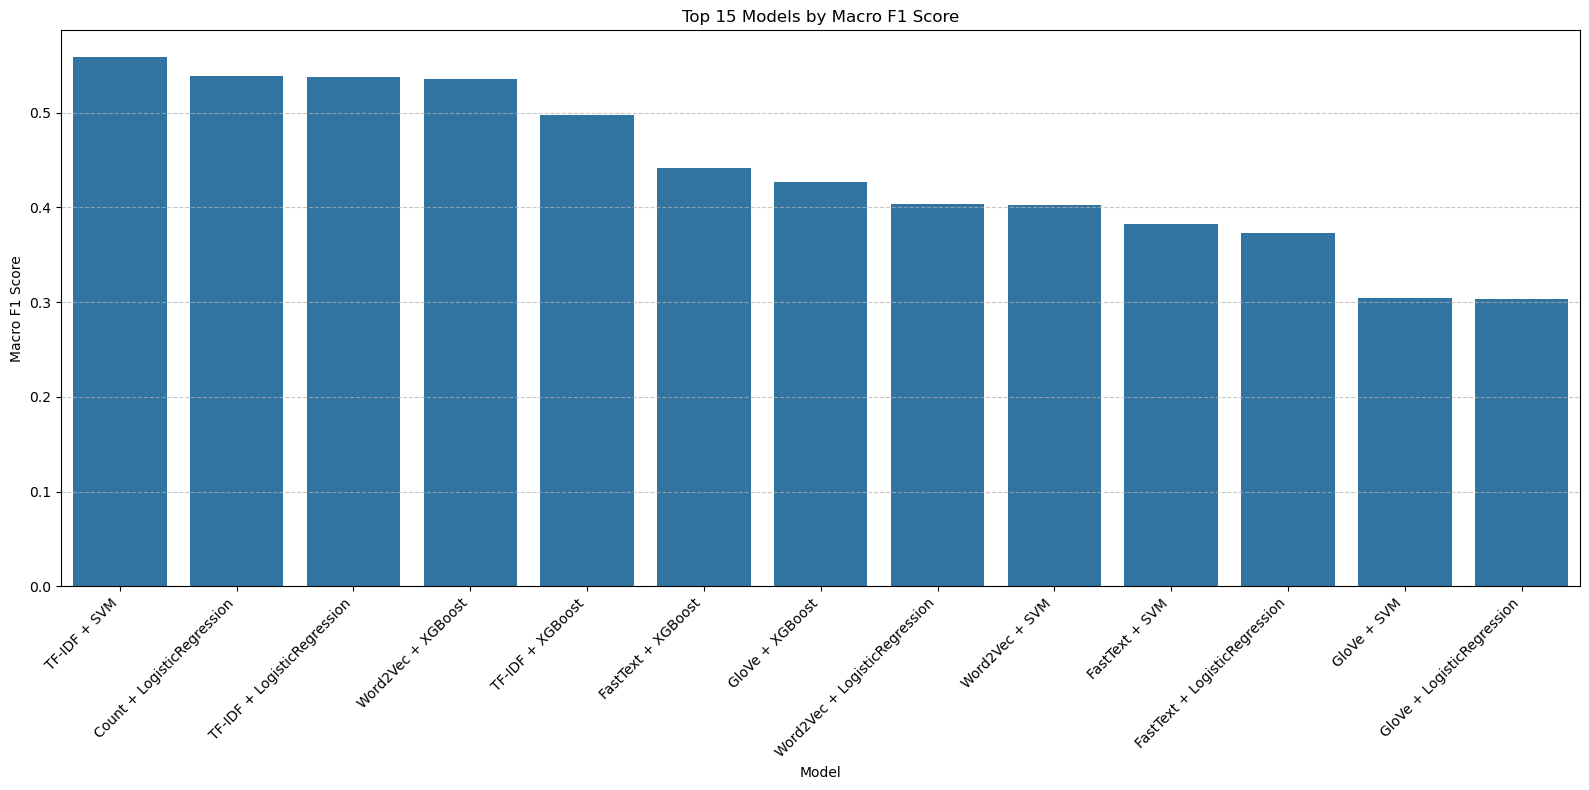

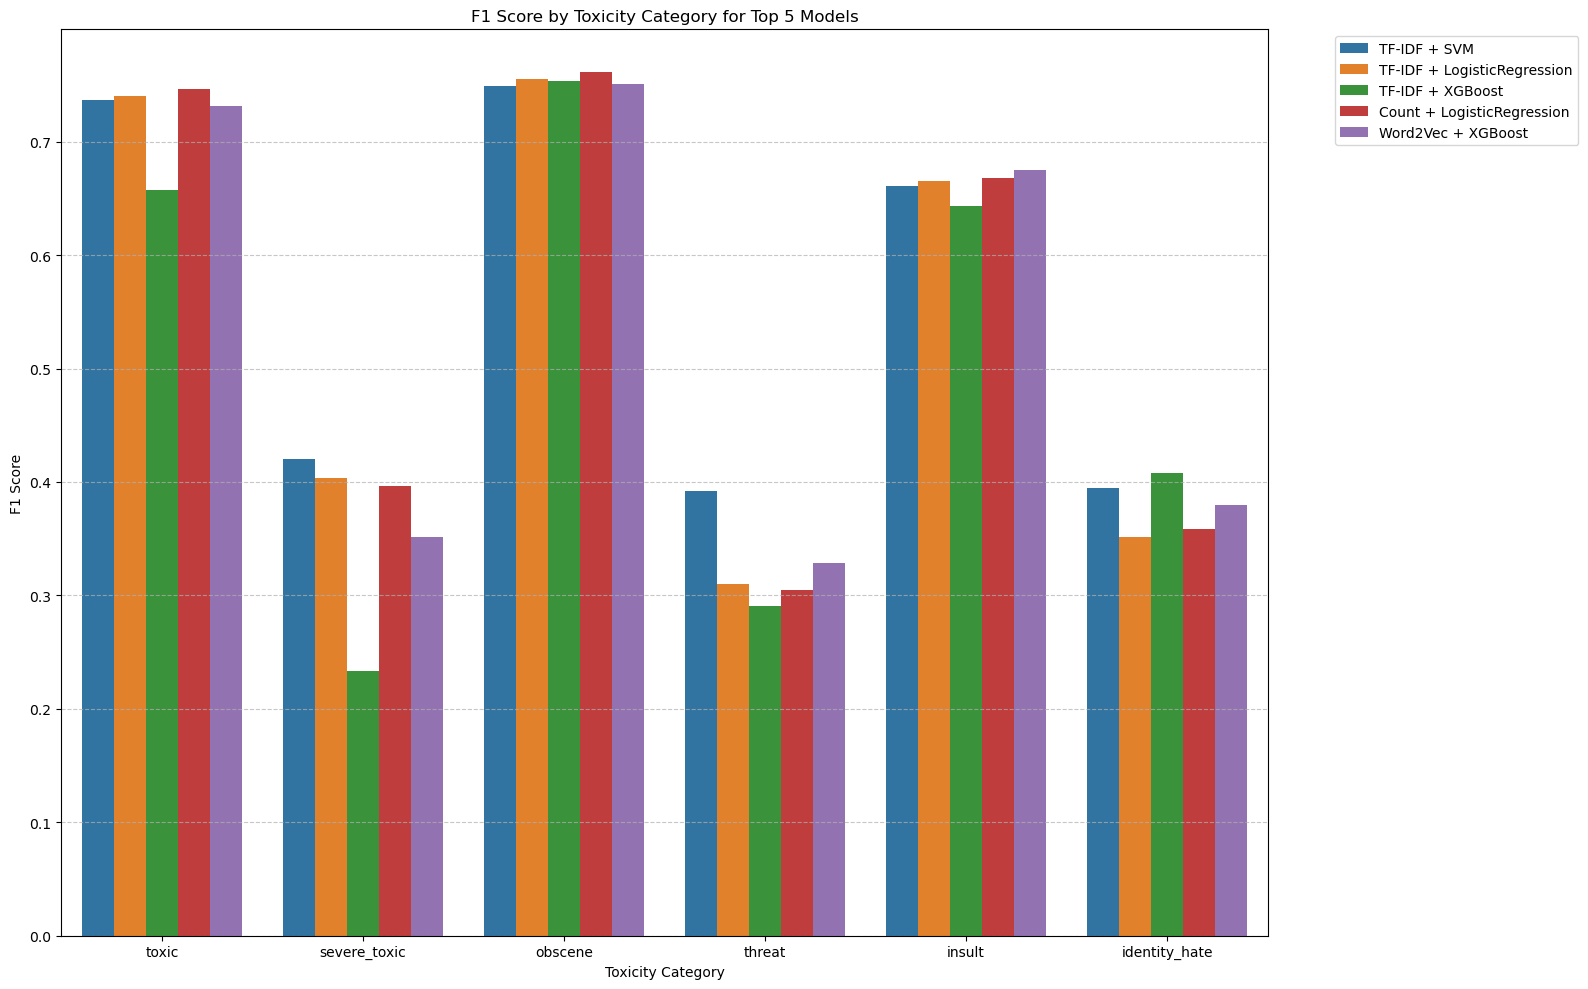


The best performing model overall is: TF-IDF + SVM


In [25]:


# Dictionary to store all results
all_classifier_results = []
all_results = []  # Initialize all_results here

# 0. Evaluate classifiers with TF-IDF vectors
print("\n\n================ EVALUATING TF-IDF WITH MULTIPLE CLASSIFIERS ================")
tfidf_results = evaluate_embeddings_with_multiple_classifiers(
    X_train_tfidf, X_val_tfidf, y_train, y_val, "TF-IDF"
)
all_classifier_results.extend(tfidf_results)

# 0.1. Evaluate Count Vectorizer with just one classifier to save time
print("\n\n================ EVALUATING COUNT VECTORIZER WITH ONE CLASSIFIER ================")
count_results = evaluate_count_with_one_classifier(
    X_train_count, X_val_count, y_train, y_val
)
all_classifier_results.extend(count_results)

# 1. Evaluate classifiers with Word2Vec embeddings
print("\n\n================ EVALUATING WORD2VEC EMBEDDINGS WITH MULTIPLE CLASSIFIERS ================")
w2v_results = evaluate_embeddings_with_multiple_classifiers(
    X_train_w2v, X_val_w2v, y_train, y_val, "Word2Vec"
)
all_classifier_results.extend(w2v_results)

# 2. Evaluate classifiers with FastText embeddings
print("\n\n================ EVALUATING FASTTEXT EMBEDDINGS WITH MULTIPLE CLASSIFIERS ================")
fasttext_results = evaluate_embeddings_with_multiple_classifiers(
    X_train_fasttext, X_val_fasttext, y_train, y_val, "FastText"
)
all_classifier_results.extend(fasttext_results)

# 3. Evaluate classifiers with GloVe embeddings
print("\n\n================ EVALUATING GLOVE EMBEDDINGS WITH MULTIPLE CLASSIFIERS ================")
glove_results = evaluate_embeddings_with_multiple_classifiers(
    X_train_glove, X_val_glove, y_train, y_val, "GloVe"
)
all_classifier_results.extend(glove_results)

# Create a combined dataframe with all results
combined_df = pd.DataFrame(all_classifier_results)

# Display all results, sorted by macro F1 score
print("\n\n================ COMBINED RESULTS FOR ALL VECTORIZERS AND CLASSIFIERS ================")
print(combined_df[['model_name', 'accuracy', 'macro_f1', 'micro_f1', 'inference_time', 'train_time']].sort_values('macro_f1', ascending=False))

# Visualize results
plt.figure(figsize=(16, 8))
sns.barplot(x='model_name', y='macro_f1', data=combined_df.sort_values('macro_f1', ascending=False).head(15))
plt.title('Top 15 Models by Macro F1 Score')
plt.xlabel('Model')
plt.ylabel('Macro F1 Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Visualize performance by toxicity category for top 5 models
top_models = combined_df.sort_values('macro_f1', ascending=False).head(5)['model_name'].tolist()

category_results = []
for result in all_classifier_results:
    if result['model_name'] in top_models:
        model_name = result['model_name']
        for col in y_val.columns:
            category_results.append({
                'model': model_name,
                'category': col,
                'f1_score': result[f'f1_{col}']
            })

category_df = pd.DataFrame(category_results)

plt.figure(figsize=(16, 10))
sns.barplot(x='category', y='f1_score', hue='model', data=category_df)
plt.title('F1 Score by Toxicity Category for Top 5 Models')
plt.xlabel('Toxicity Category')
plt.ylabel('F1 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# No need for the old way of storing results - we've already evaluated everything together
results_df = pd.DataFrame(all_classifier_results)
best_model_name = results_df.sort_values('macro_f1', ascending=False).iloc[0]['model_name']
print(f"\nThe best performing model overall is: {best_model_name}")

In [ ]:
results_df

In [ ]:
# Create organized directory structure
os.makedirs('../results/vectorizers_models', exist_ok=True)
os.makedirs('../models/vectorizers', exist_ok=True)

# Save the results dataframe to CSV and pickle in the vectorizers_models subfolder
results_df.to_csv('../results/vectorizers_models/model_comparison_results.csv', index=False)
results_df.to_pickle('../results/vectorizers_models/model_comparison_results.pkl')

# Collect shape information for all feature representations
feature_shapes = {
    'TF-IDF': X_train_tfidf.shape,
    'Count': X_train_count.shape,
    'Word2Vec': X_train_w2v.shape,
    'FastText': X_train_fasttext.shape,
    'GloVe': X_train_glove.shape
}

# Save the feature shape information in the vectorizers_models subfolder
with open('../results/vectorizers_models/feature_shapes.txt', 'w') as f:
    f.write("Feature representation shapes:\n")
    for name, shape in feature_shapes.items():
        f.write(f"{name}: {shape}\n")

# Save all vectorizers in the vectorizers subfolder
vectorizers = {
    'tfidf': tfidf_vectorizer,
    'count': count_vectorizer,
    'word2vec': w2v_vectorizer,
    'fasttext': fasttext_vectorizer,
    'glove': glove_vectorizer
}

for name, vectorizer in vectorizers.items():
    with open(f'../models/vectorizers/{name}_vectorizer.pkl', 'wb') as f:
        pickle.dump(vectorizer, f)

# Save best classifier information in the vectorizers_models subfolder
embedding_types = ['TF-IDF', 'Word2Vec', 'FastText', 'GloVe']
embedding_results = {
    'TF-IDF': tfidf_results,
    'Word2Vec': w2v_results,
    'FastText': fasttext_results,
    'GloVe': glove_results
}

best_classifiers = {}
for embedding_type in embedding_types:
    # Find best classifier for this embedding
    best_result = max(embedding_results[embedding_type], key=lambda x: x['macro_f1'])
    best_classifier_type = best_result['model_name'].split(' + ')[1]
    best_classifiers[embedding_type] = best_classifier_type
    print(f"Best classifier for {embedding_type}: {best_classifier_type}")

# Save best classifier information
with open('../results/vectorizers_models/best_classifiers.txt', 'w') as f:
    f.write("Best classifier for each embedding type:\n")
    for embedding_type, classifier_type in best_classifiers.items():
        f.write(f"{embedding_type}: {classifier_type}\n")

# Print feature shape summary
print("\nFeature representation shapes:")
for name, shape in feature_shapes.items():
    print(f"{name}: {shape}")

print("\nAll vectorizers and model results saved in the organized folder structure.")

In [ ]:
results_df